<a href="https://colab.research.google.com/github/wieczorek-daniel/letters-recognition/blob/master/letters_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install emnist
from emnist import extract_training_samples
from emnist import extract_test_samples

import tensorflow as tf
from tensorflow.keras import layers as lyrs
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img

from matplotlib import pyplot as plt
import numpy as np
import random
import os
import cv2

In [0]:
train_images, train_labels = extract_training_samples('letters')
test_images, test_labels = extract_test_samples('letters')

In [0]:
train_images = tf.keras.utils.normalize(train_images, axis=1)
test_images = tf.keras.utils.normalize(test_images, axis=1)

In [0]:
img_height = train_images.shape[1]
img_width = train_images.shape[2]
classes_number = 27
train_number = train_images.shape[0]
test_number = test_images.shape[0]
print('Number of train images: ', train_number, '\nNumber of test images: ', test_number)

In [0]:
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.axis('off')
plt.show()

plt.figure(figsize=(16,8))
plt.hist(train_images[0].ravel(), bins = 256)
plt.show()

In [0]:
tf.keras.backend.set_floatx('float64')

In [0]:
# Model 1 - 87.8% accuracy (3 epochs), but fast
model_number = 1

model = tf.keras.models.Sequential([
          lyrs.Flatten(),
          lyrs.Dense(128, activation=tf.nn.relu),
          lyrs.Dense(128, activation=tf.nn.relu),
          lyrs.Dense(classes_number, activation=tf.nn.softmax)
])

In [0]:
# Model 2 - 90.71% accuracy (3 epochs), but slower
model_number = 2

train_images = train_images.reshape(train_images.shape[0], img_height, img_width, 1)
test_images = test_images.reshape(test_images.shape[0], img_height, img_width, 1)

model = tf.keras.models.Sequential([
          lyrs.Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(img_height, img_width, 1)),
          lyrs.MaxPooling2D(pool_size=(2, 2)),
          lyrs.Flatten(),
          lyrs.Dense(128, activation='relu'),
          lyrs.Dense(classes_number, activation='softmax')
])

In [0]:
# Model 3 - 93.58% accuracy (3 epochs)
model_number = 3

tf.keras.backend.set_floatx('float32')
train_images = train_images.reshape(train_images.shape[0], img_height, img_width, 1)
test_images = test_images.reshape(test_images.shape[0], img_height, img_width, 1)

model = tf.keras.models.Sequential([
         lyrs.Conv2D(32, (5, 5), input_shape=(img_height, img_width, 1)),
         lyrs.BatchNormalization(axis=-1),
         lyrs.Activation('relu'),
         lyrs.Conv2D(32, (4, 4)),
         lyrs.BatchNormalization(axis=-1),
         lyrs.Activation('relu'),
         lyrs.MaxPooling2D(pool_size=(2, 2)),

         lyrs.Conv2D(64, (3, 3)),
         lyrs.BatchNormalization(axis=-1),
         lyrs.Activation('sigmoid'),
         lyrs.Conv2D(64, (3, 3)),
         lyrs.BatchNormalization(axis=-1),
         lyrs.Activation('relu'),
         lyrs.MaxPooling2D(pool_size=(2, 2)),

         lyrs.Flatten(),

         # Fully connected layer
         lyrs.Dense(512),
         lyrs.BatchNormalization(),
         lyrs.Activation('relu'),
         lyrs.Dropout(0.2),

         lyrs.Dense(classes_number, activation='softmax')
])

In [0]:
# Model 4 - 92.52% accuracy (3 epochs)
model_number = 4

tf.keras.backend.set_floatx('float32')
train_images = train_images.reshape(train_images.shape[0], img_height, img_width, 1)
test_images = test_images.reshape(test_images.shape[0], img_height, img_width, 1)

model = tf.keras.models.Sequential([
         lyrs.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(img_height, img_width, 1), activation='relu'),
         lyrs.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(img_height, img_width, 1), activation='relu'),
         lyrs.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
         lyrs.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(img_height, img_width, 1), activation='relu'),
         lyrs.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(img_height, img_width, 1), activation='relu'),
         lyrs.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
         lyrs.Dropout(0.2),
         lyrs.Flatten(),
         lyrs.Dense(units=128, activation='relu', kernel_initializer='uniform'),
         lyrs.Dense(units=64, activation='relu', kernel_initializer='uniform'),
         lyrs.Dense(units=classes_number, activation='softmax', kernel_initializer='uniform')
])

In [0]:
# Reload model before start
print('Selected model: ', model_number)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


val_split = 0.16
print('Number of train images: ', train_number-int(train_number*val_split), '\nNumber of validation images: ', int(train_number*val_split))
sequential_model = model.fit(train_images, train_labels, validation_split=val_split, epochs=5, shuffle=True, batch_size=64)

In [0]:
model.summary()

In [0]:
plot_model(model, to_file='model.png')

In [0]:
# Plot training and validation accuracy values
plt.plot(sequential_model.history['accuracy'])
plt.plot(sequential_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# Plot training and validation loss values
plt.figure(figsize=(8,6))
plt.plot(sequential_model.history['loss'])
plt.plot(sequential_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.axvline(x=13, color='k')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
validation_lose, validation_accuracy = model.evaluate(test_images, test_labels)
print('Test images validation:')
print('Validation lose: ', validation_lose, '\nValidation accuracy:', validation_accuracy)

In [0]:
model.save('letters.model')

In [0]:
input_model = tf.keras.models.load_model('letters.model')

In [0]:
test_images = test_images.reshape(test_images.shape[0], img_height, img_width, 1)
predictions = input_model.predict(test_images)

In [0]:
labels_letter = {0:'', 1:'A', 2:'B', 3:'C', 4:'D', 5:'E', 6:'F', 7:'G', 8:'H', 9:'I', 10:'J', 11:'K', 12:'L', 13:'M',
                 14:'N', 15:'O', 16:'P', 17:'Q', 18:'R', 19:'S', 20:'T', 21:'U', 22:'V', 23:'W', 24:'X', 25:'Y', 26:'Z', 27:''}
letters = (i for i in range(1,27))
print({key: labels_letter[key] for key in letters})
letters_number = 26

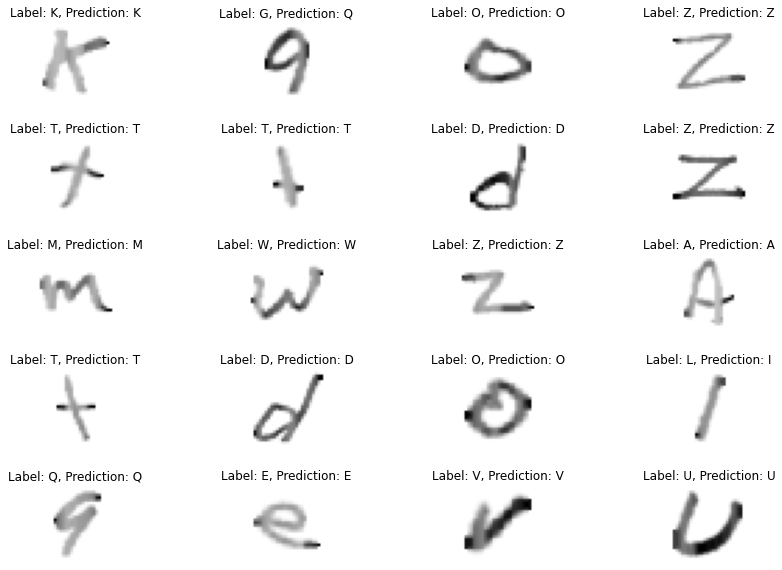

In [0]:
test_images = test_images.reshape(test_images.shape[0], img_height, img_width)
rows = 5
cols = 4
figure, axis = plt.subplots(rows, cols)
plt.subplots_adjust(right=2, top=2, hspace=0.5)

for i in range(0,rows):
  for j in range(0,cols):
    sample = random.randint(0, test_images.shape[0])
    axis[i, j].imshow(test_images[sample], cmap=plt.cm.binary)
    axis[i, j].set_title('Label: {0}, Prediction: {1}'.format(labels_letter[test_labels[sample]], labels_letter[np.argmax(predictions[sample])]))
    axis[i, j].axis('off')
plt.show()

In [0]:
correct = [0]*26;
incorrect = [0]*26;
error = [0]*26
all = 0;

print('Incorrect error [%]')

for element in range(test_number):
  for label in range(letters_number+1):
    if labels_letter[test_labels[element]] == labels_letter[label+1]:
      if labels_letter[np.argmax(predictions[element])] == labels_letter[label+1]:
        correct[label]+=1
      else:
        incorrect[label]+=1
      all+=1

for letter in range(letters_number):
  error[letter]=(incorrect[letter]/(correct[letter]+incorrect[letter]))*100
  print(labels_letter[letter+1], ': ', error[letter], '%')
print('All: ', all)

Incorrect error [%]
A :  3.0 %
B :  4.0 %
C :  1.7500000000000002 %
D :  7.625 %
E :  3.5000000000000004 %
F :  3.25 %
G :  17.875 %
H :  7.375 %
I :  12.75 %
J :  4.75 %
K :  2.875 %
L :  44.75 %
M :  0.625 %
N :  5.25 %
O :  2.875 %
P :  1.25 %
Q :  15.5 %
R :  3.25 %
S :  2.875 %
T :  3.125 %
U :  4.0 %
V :  6.5 %
W :  5.875 %
X :  5.375 %
Y :  4.375 %
Z :  1.375 %
All:  20800


In [0]:
handwritten_uppercase = np.zeros((letters_number, img_height, img_width))
handwritten_lowercase = np.zeros((letters_number, img_height, img_width))

uppercase_dir='/content/drive/My Drive/Colab Notebooks/handwritten-letters/uppercase'
lowercase_dir='/content/drive/My Drive/Colab Notebooks/handwritten-letters/lowercase'

for number, image in enumerate(os.listdir(uppercase_dir)):
  image = load_img(os.path.join(uppercase_dir, image), color_mode = 'grayscale', target_size=(img_height, img_width))
  image = np.invert(image)
  image = cv2.fastNlMeansDenoising(image) 
  #image = np.invert(image)
  handwritten_uppercase[number, :] = image

for number, image in enumerate(os.listdir(lowercase_dir)):
  image = load_img(os.path.join(lowercase_dir, image), color_mode = 'grayscale', target_size=(img_height, img_width))
  image = np.invert(image)
  image = cv2.fastNlMeansDenoising(image) 
  #image = np.invert(image)
  handwritten_lowercase[number, :] = image

handwritten_uppercase = tf.keras.utils.normalize(handwritten_uppercase, axis=1)
handwritten_lowercase = tf.keras.utils.normalize(handwritten_lowercase, axis=1)

handwritten_uppercase = handwritten_uppercase.reshape(handwritten_uppercase.shape[0], img_height, img_width, 1)
handwritten_lowercase = handwritten_lowercase.reshape(handwritten_lowercase.shape[0], img_height, img_width, 1)

uppercase_predictions = input_model.predict(handwritten_uppercase)
lowercase_predictions = input_model.predict(handwritten_lowercase)

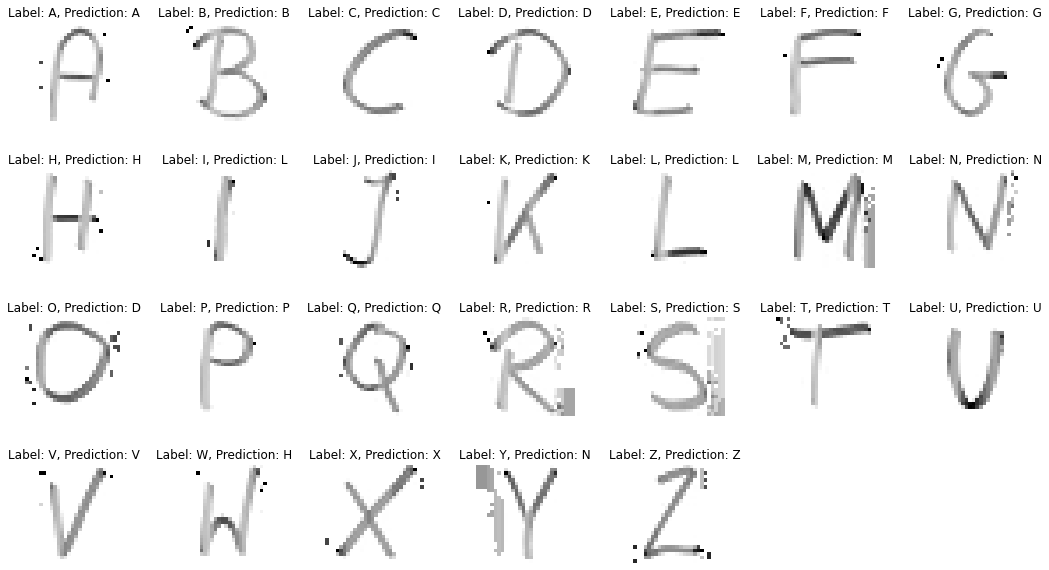

In [0]:
handwritten_uppercase = handwritten_uppercase.reshape(handwritten_uppercase.shape[0], img_height, img_width)
rows = 4
cols = 7
figure, axis = plt.subplots(rows, cols)
plt.subplots_adjust(right=2.5, top=2, hspace=0.5)
image_number = 0

for i in range(0,rows):
  for j in range(0,cols):
    axis[3, 5].set_visible(False)
    axis[3, 6].set_visible(False)
    axis[i, j].imshow(handwritten_uppercase[image_number], cmap=plt.cm.binary)
    axis[i, j].set_title('Label: {0}, Prediction: {1}'.format(labels_letter[image_number+1], labels_letter[np.argmax(uppercase_predictions[image_number])]))
    axis[i, j].axis('off')
    image_number += 1
    if image_number > 25:
      break
      
plt.show()

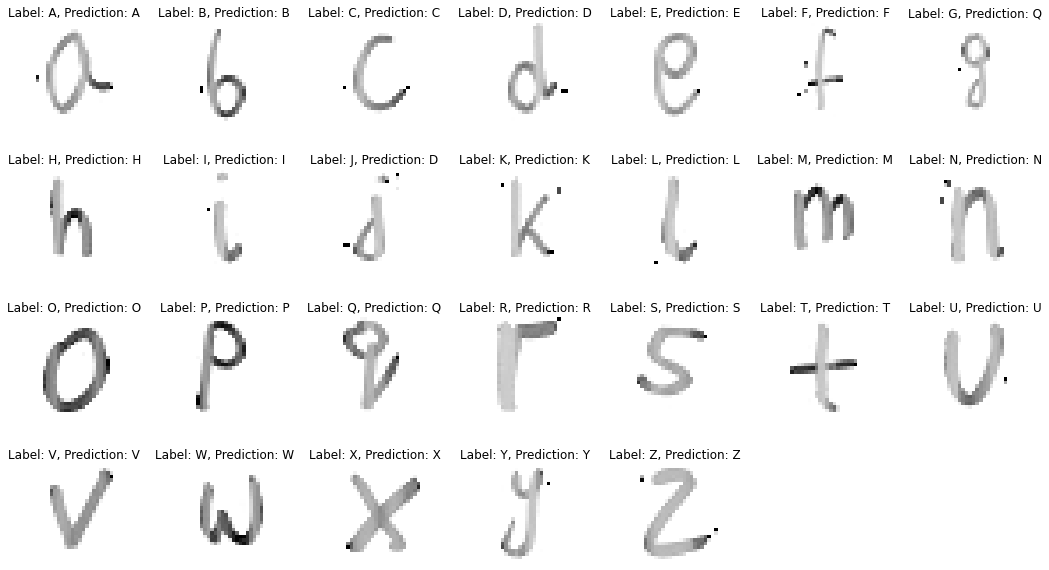

In [0]:
handwritten_lowercase = handwritten_lowercase .reshape(handwritten_lowercase .shape[0], img_height, img_width)
rows = 4
cols = 7
figure, axis = plt.subplots(rows, cols)
plt.subplots_adjust(right=2.5, top=2, hspace=0.5)
image_number = 0

for i in range(0,rows):
  for j in range(0,cols):
    axis[3, 5].set_visible(False)
    axis[3, 6].set_visible(False)
    axis[i, j].imshow(handwritten_lowercase [image_number], cmap=plt.cm.binary)
    axis[i, j].set_title('Label: {0}, Prediction: {1}'.format(labels_letter[image_number+1], labels_letter[np.argmax(lowercase_predictions[image_number])]))
    axis[i, j].axis('off')
    image_number += 1
    if image_number > 25:
      break
      
plt.show()